# ADVANCED COMPUTER VISION
## Assignment 6
### Ishang Kansal | E22CSEU0320

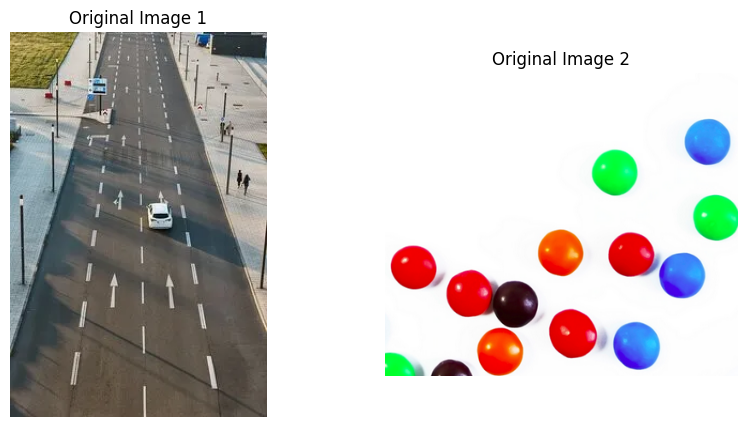

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image1 = cv2.imread("Lanes.png")  
image2 = cv2.imread("image.png")  

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title("Original Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title("Original Image 2")
plt.axis("off")

plt.show()

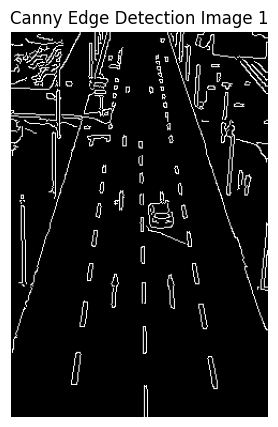

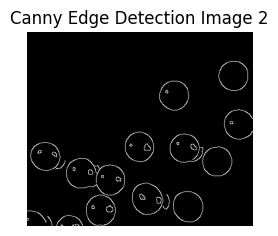

In [2]:
blurred1 = cv2.GaussianBlur(gray1, (5, 5), 0)
blurred2 = cv2.GaussianBlur(gray2, (5, 5), 0)

edges1 = cv2.Canny(blurred1, 50, 150, apertureSize=3)
edges2 = cv2.Canny(blurred2, 50, 150, apertureSize=3)

plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.imshow(edges1, cmap="gray")
plt.title("Canny Edge Detection Image 1")
plt.axis("off")
plt.show()

plt.subplot(1,2,2)
plt.imshow(edges2, cmap="gray")
plt.title("Canny Edge Detection Image 2")
plt.axis("off")

plt.show()

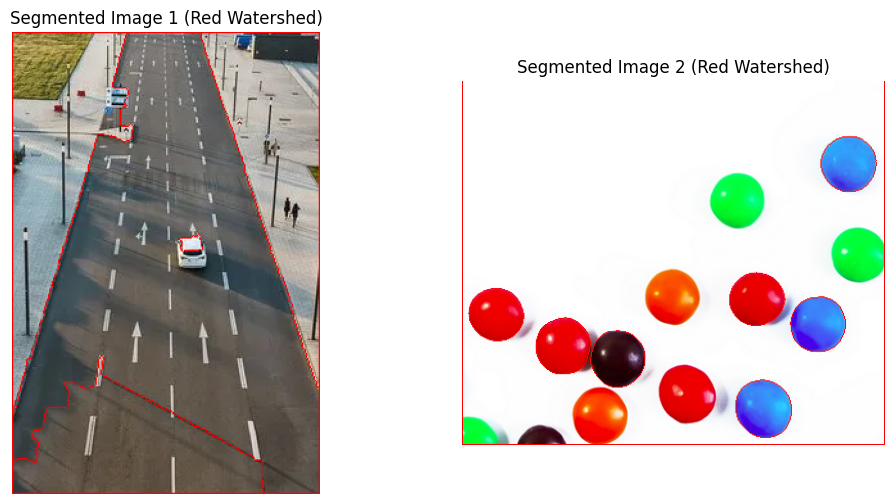

In [3]:
def apply_watershed(image, gray):
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    sure_bg = cv2.dilate(thresh, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    image_copy = image.copy()
    cv2.watershed(image_copy, markers)
    
    image_copy[markers == -1] = [0, 0, 255]
    return image_copy

segmented1 = apply_watershed(image1, gray1)
segmented2 = apply_watershed(image2, gray2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cv2.cvtColor(segmented1, cv2.COLOR_BGR2RGB))
axes[0].set_title("Segmented Image 1 (Red Watershed)")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(segmented2, cv2.COLOR_BGR2RGB))
axes[1].set_title("Segmented Image 2 (Red Watershed)")
axes[1].axis("off")

plt.show()

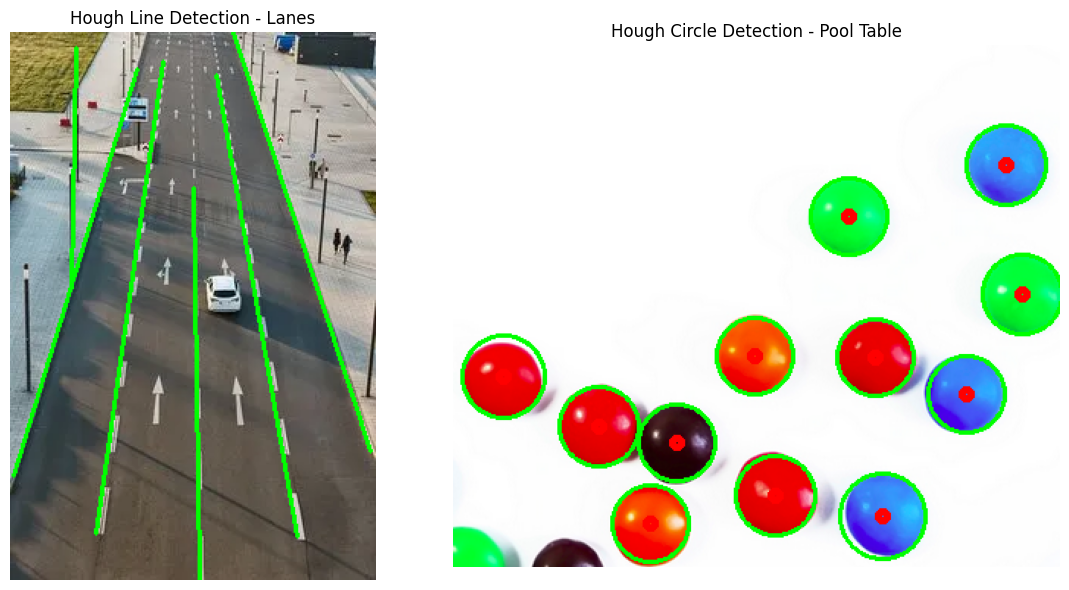

In [4]:
def detect_lines(image, edges):
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=150)
    image_lines = image.copy()
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)  

    return image_lines

def detect_circles(image, gray):
    image_circles = image.copy()
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=40, param1=50, param2=50, minRadius=20, maxRadius=80)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(image_circles, (i[0], i[1]), i[2], (0, 255, 0), 2) 
            cv2.circle(image_circles, (i[0], i[1]), 3, (0, 0, 255), 3)   

    return image_circles

image1_lines = detect_lines(image1, edges1)
image2_circles = detect_circles(image2, gray2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cv2.cvtColor(image1_lines, cv2.COLOR_BGR2RGB))
axes[0].set_title("Hough Line Detection - Lanes")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(image2_circles, cv2.COLOR_BGR2RGB))
axes[1].set_title("Hough Circle Detection - Pool Table")
axes[1].axis("off")

plt.tight_layout()
plt.show()

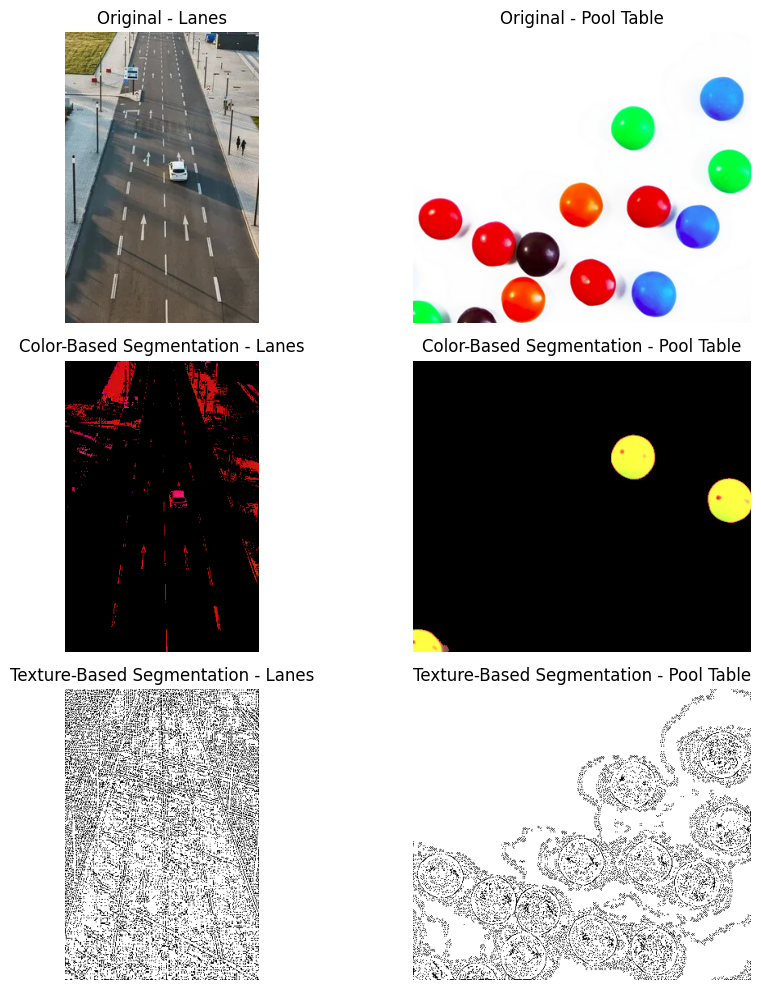

In [7]:
from skimage.filters import gabor
from skimage.feature import local_binary_pattern

image_lanes = cv2.imread("Lanes.png") 
image_pool = cv2.imread("image.png")

hsv_lanes = cv2.cvtColor(image_lanes, cv2.COLOR_BGR2HSV)
hsv_pool = cv2.cvtColor(image_pool, cv2.COLOR_BGR2HSV)

def color_segmentation(image, lower_range, upper_range):
    mask = cv2.inRange(image, lower_range, upper_range)
    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented, mask

lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 50, 255])

lower_green = np.array([35, 40, 40])  
upper_green = np.array([85, 255, 255])

lanes_color_seg, lanes_mask = color_segmentation(hsv_lanes, lower_white, upper_white)
pool_color_seg, pool_mask = color_segmentation(hsv_pool, lower_green, upper_green)

def texture_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gabor_filtered, _ = gabor(gray, frequency=0.6)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    
    gabor_norm = cv2.normalize(gabor_filtered, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    lbp_norm = cv2.normalize(lbp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    texture_combined = cv2.addWeighted(gabor_norm, 0.5, lbp_norm, 0.5, 0)
    
    _, texture_mask = cv2.threshold(texture_combined, 50, 255, cv2.THRESH_BINARY)
    
    return texture_combined, texture_mask

lanes_texture_seg, lanes_texture_mask = texture_segmentation(image_lanes)
pool_texture_seg, pool_texture_mask = texture_segmentation(image_pool)

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes[0, 0].imshow(cv2.cvtColor(image_lanes, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Original - Lanes")

axes[0, 1].imshow(cv2.cvtColor(image_pool, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("Original - Pool Table")

axes[1, 0].imshow(cv2.cvtColor(lanes_color_seg, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title("Color-Based Segmentation - Lanes")

axes[1, 1].imshow(cv2.cvtColor(pool_color_seg, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title("Color-Based Segmentation - Pool Table")

axes[2, 0].imshow(lanes_texture_mask, cmap="gray")
axes[2, 0].set_title("Texture-Based Segmentation - Lanes")

axes[2, 1].imshow(pool_texture_mask, cmap="gray")
axes[2, 1].set_title("Texture-Based Segmentation - Pool Table")

for ax in axes.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 94s 1us/step


c:\Users\ishan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.0813 - loss: 4.1144 - val_accuracy: 0.2142 - val_loss: 3.3127
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.2357 - loss: 3.1568 - val_accuracy: 0.2805 - val_loss: 2.9417
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.3099 - loss: 2.8034 - val_accuracy: 0.3114 - val_loss: 2.7772
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.3495 - loss: 2.5872 - val_accuracy: 0.3322 - val_loss: 2.6630
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.3813 - loss: 2.4347 - val_accuracy: 0.3539 - val_loss: 2.5930
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.4116 - loss: 2.2888 - val_accuracy: 0.3583 - val_loss: 2.5629
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.4365 - loss: 2.1814 - val_accuracy: 0.3655 - val_loss: 2.5286
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.4624 - loss: 2.0581 - 

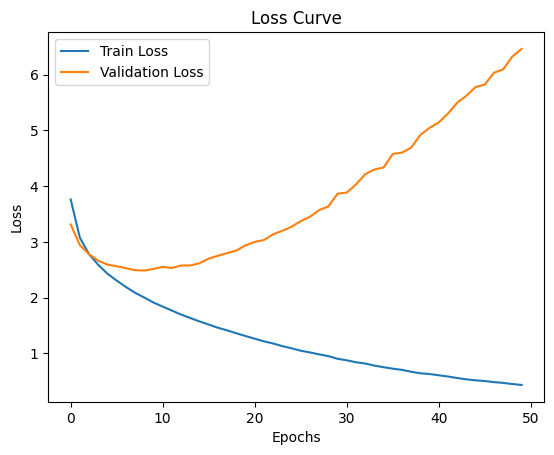

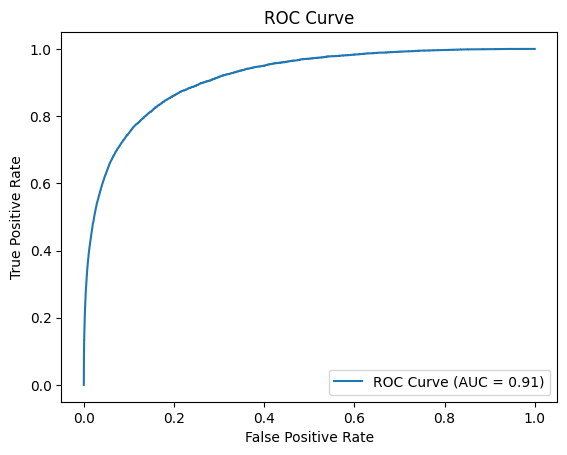

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


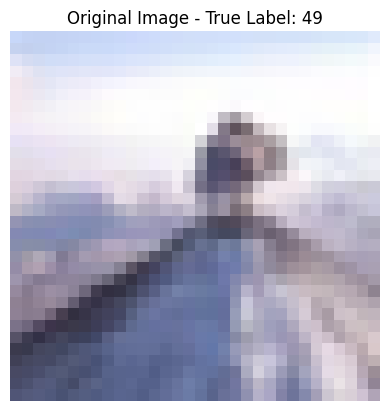

Predicted Label: 68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


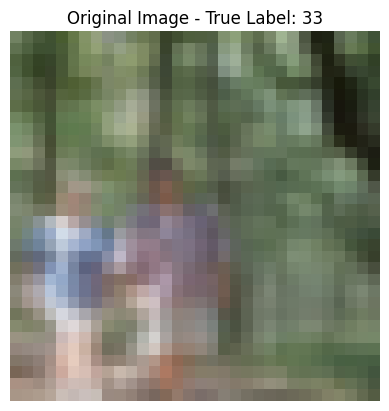

Predicted Label: 33


In [8]:
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

num_classes = 100
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test))

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred, output_dict=True)
precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

def predict_and_show(image_index):
    test_image = np.expand_dims(x_test[image_index], axis=0)  
    prediction = model.predict(test_image)
    predicted_label = np.argmax(prediction)

    plt.imshow(x_test[image_index])
    plt.title(f"Original Image - True Label: {y_true[image_index]}")
    plt.axis("off")
    plt.show()

    print(f"Predicted Label: {predicted_label}")

predict_and_show(0)
predict_and_show(1)


image 1/1 c:\Users\ishan\OneDrive\Desktop\EXTRA\Semester 6 Data\CSET340\temp1.png: 640x448 4 persons, 2 cars, 1 truck, 211.0ms
Speed: 13.7ms preprocess, 211.0ms inference, 13.2ms postprocess per image at shape (1, 3, 640, 448)

📌 Objects detected in temp1.png:
🔹 person: 0.52
🔹 person: 0.47
🔹 person: 0.36
🔹 car: 0.33
🔹 truck: 0.31
🔹 car: 0.31
🔹 person: 0.26


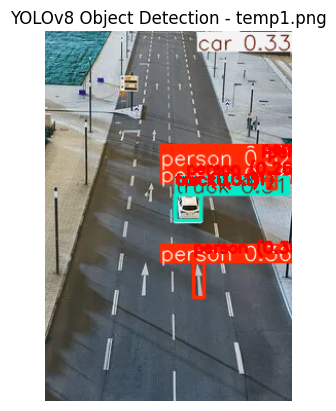


image 1/1 c:\Users\ishan\OneDrive\Desktop\EXTRA\Semester 6 Data\CSET340\temp2.png: 576x640 5 sports balls, 1 apple, 2 oranges, 188.9ms
Speed: 5.7ms preprocess, 188.9ms inference, 9.3ms postprocess per image at shape (1, 3, 576, 640)

📌 Objects detected in temp2.png:
🔹 orange: 0.80
🔹 sports ball: 0.58
🔹 sports ball: 0.55
🔹 orange: 0.55
🔹 sports ball: 0.44
🔹 sports ball: 0.44
🔹 apple: 0.40
🔹 sports ball: 0.25


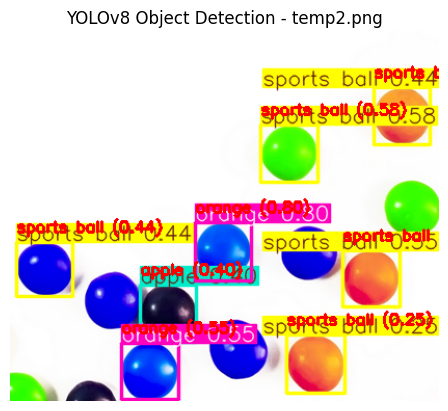

In [9]:
from ultralytics import YOLO
import os

model = YOLO("yolov8n.pt")

def detect_and_show(image, temp_filename="temp_image.jpg"):
    if image is None:
        print("❌ Error: Image is not loaded properly.")
        return

    cv2.imwrite(temp_filename, image)

    results = model.predict(temp_filename, save=False, verbose=True)

    for r in results:
        image_with_boxes = r.plot()
        
        print(f"\n📌 Objects detected in {temp_filename}:")
        for box in r.boxes.data:
            x1, y1, x2, y2, confidence, class_id = box.tolist()
            class_name = model.names[int(class_id)]  
            print(f"🔹 {class_name}: {confidence:.2f}")

            label = f"{class_name} ({confidence:.2f})"
            cv2.putText(image_with_boxes, label, (int(x1), int(y1) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(image_with_boxes)
    plt.title(f"YOLOv8 Object Detection - {temp_filename}")
    plt.axis("off")
    plt.show()

    os.remove(temp_filename)

image1 = cv2.imread("Lanes.png")  
image2 = cv2.imread("image.png")  

if image1 is None or image2 is None:
    print("❌ Error: Could not load one or both images. Check file paths.")
else:
    detect_and_show(image1, "temp1.png")
    detect_and_show(image2, "temp2.png")

c:\Users\ishan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ishan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



📌 Objects detected in Lanes.png:
🔹 Class 1: 1.00
🔹 Class 1: 0.99
🔹 Class 8: 0.93
🔹 Class 1: 0.76
🔹 Class 3: 0.71
🔹 Class 62: 0.62


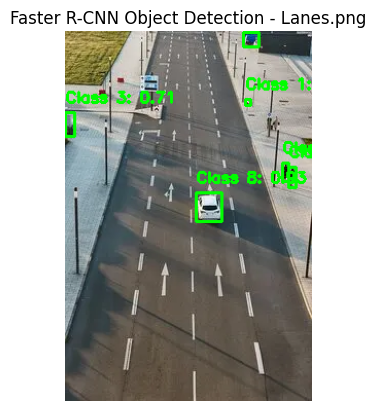


📌 Objects detected in image.png:
🔹 Class 34: 0.92
🔹 Class 34: 0.91
🔹 Class 34: 0.87
🔹 Class 37: 0.76
🔹 Class 34: 0.69
🔹 Class 34: 0.67
🔹 Class 34: 0.62


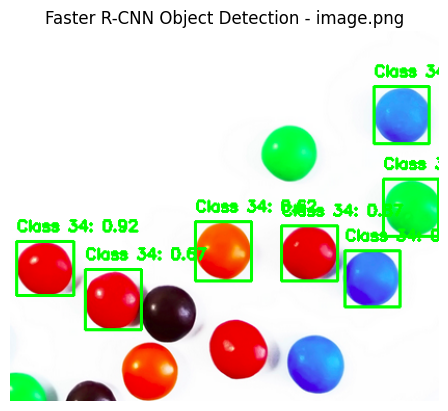

In [10]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests

model_frcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_frcnn.eval()

coco_labels_url = "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_labels.txt"
coco_labels = requests.get(coco_labels_url).text.strip().split("\n")

def detect_and_show(image_path, confidence_threshold=0.6):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)  

    with torch.no_grad():
        predictions = model_frcnn(image_tensor)

    image_cv = cv2.imread(image_path)

    print(f"\n📌 Objects detected in {image_path}:")
    
    for i, box in enumerate(predictions[0]["boxes"]):
        score = predictions[0]["scores"][i].item()
        if score > confidence_threshold: 
            x1, y1, x2, y2 = map(int, box)
            class_id = int(predictions[0]["labels"][i].item())  

            class_name = coco_labels[class_id] if class_id < len(coco_labels) else f"Class {class_id}"

            cv2.rectangle(image_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"{class_name}: {score:.2f}"
            print(f"🔹 {label}")

            cv2.putText(image_cv, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    plt.title(f"Faster R-CNN Object Detection - {image_path}")
    plt.axis("off")
    plt.show()

detect_and_show("Lanes.png")  
detect_and_show("image.png")  